# 1. Install and Import Dependencies

In [1]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
!pip install transformers requests beautifulsoup4 pandas numpy

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

# 2. Instantiate Model

In [4]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# 3. Encode and Calculate Sentiment

In [5]:
sentence = "It was ok"
tokens = tokenizer.encode(sentence, return_tensors='pt')
result = model(tokens)
result.logits
int(torch.argmax(result.logits))+1

3

# 3.5 Import Data

In [6]:
import os
import pandas as pd

In [7]:
os.listdir("./data/")

['RS_2021-06.json',
 'RS_2021-06.zst',
 'disney_all_subs_w_dates.csv',
 'reddit.csv',
 'twitter.csv']

In [8]:
df = pd.read_csv("./data/disney_all_subs_w_dates.csv")

/home/clark/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,1,4,5,6,8,9,10,11,12,16,18,19,20,21,22,24,25,26,27,28,29,30,31,35,37,39,43,44,45,49,53,56,58,59,60,61,62,65,66,67,68,71,73,74,75,77,78,79,80) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
len(df)

99274

In [10]:
df.selftext[:100]

0                                             [deleted]
1                                             [deleted]
2                                                   NaN
3                                             [deleted]
4                                                   NaN
                            ...                        
95                                                  NaN
96                                            [deleted]
97                                                  NaN
98                                                  NaN
99    Maybe it’d be better than to be scooped up by ...
Name: selftext, Length: 100, dtype: object

In [11]:
df2 = df.selftext.isnull()

In [12]:
type(df2)

pandas.core.series.Series

In [13]:
df2[:10]

0    False
1    False
2     True
3    False
4     True
5     True
6     True
7     True
8     True
9     True
Name: selftext, dtype: bool

In [14]:
df3 = df[df2 == False]

In [15]:
df3.selftext[:10]

0     [deleted]
1     [deleted]
3     [deleted]
10    [removed]
12    [removed]
13    [removed]
14    [removed]
18    [deleted]
22    [removed]
25    [deleted]
Name: selftext, dtype: object

In [16]:
df4 = df3[df3.selftext != "[deleted]"]

In [17]:
df5 = df4[df4.selftext != "[removed]"]

In [18]:
df5.selftext[:10]

38      As you probably are aware, Magic Bands have a ...
62      hello, my mother, me and her best friend and s...
99      Maybe it’d be better than to be scooped up by ...
298     Like the title says, I was hoping to find some...
970     The concept art may look promising that Disney...
1406    First of all, I'm not from the US so I don't k...
1442    So a few weeks ago, I came home to my wife wat...
1472    So I'm planning to binge-watch "The Lion Guard...
1478                      Anyone have any they just love?
1510    I have been SCOURING the internet for weeks fo...
Name: selftext, dtype: object

In [19]:
len(df5)

11527

In [20]:
df6 = df5[df5.selftext.apply(lambda x: len(str(x)) < 512)]

In [36]:
len(df6)

8093

In [38]:
df6.to_csv('./data/disney_all_subs_cleaned.csv', header=True, index=False, columns=list(df6.axes[1]))

In [22]:
sentence = df5.iloc[0].selftext

In [23]:
list1 = []

In [24]:
df6.iloc[0].selftext

'hello, my mother, me and her best friend and son are going to disney in a few months and i was wondering if disney allows autistic persons to buddy up with underage kids (i want to buddy up with my moms friends son who is 21 and has autism) not trying to be rude but some theme parks don’t allow that'

In [25]:
from tqdm.notebook import tqdm

In [26]:
with tqdm(total=len(df6)) as pbar:
    for i in range(len(df6)):
        tokens = tokenizer.encode(df6.iloc[i].selftext, return_tensors='pt')
        result = model(tokens)
        result.logits
        list1.append(int(torch.argmax(result.logits))+1)
        pbar.update(1)

  0%|          | 0/8093 [00:00<?, ?it/s]

In [27]:
type(list1)

list

In [28]:
list1[:10]

[4, 2, 4, 2, 2, 3, 5, 5, 3, 3]

In [29]:
list2 = pd.Series(list1)

In [30]:
len(list2)

8093

In [31]:
list3 = list2.rename("sentiment")

In [115]:
list3.head(10)

0    4
1    2
2    4
3    2
4    2
5    3
6    5
7    5
8    3
9    3
Name: sentiment, dtype: int64

In [137]:
df7 = df6.reset_index(drop=True)

In [138]:
result = df7.join(list3)

In [139]:
result.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,...,is_gallery,gallery_data,media_metadata,edited,banned_by,author_cakeday,author_is_blocked,is_created_from_ads_ui,creation_date,sentiment
0,[],True,katekolstee,NaN,[],NaN,text,t2_5iybhij2,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03-03-2021,4
1,[],False,NoodleSnekk,NaN,[],NaN,text,t2_5oxvpicy,False,False,...,NaN,NaN,NaN,1.614477e+09,NaN,NaN,NaN,NaN,02-28-2021,2
2,[],True,Suitable-Concert,NaN,[],NaN,text,t2_4vdaawwq,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12-18-2020,4
3,[],False,rwinger24,NaN,[],NaN,text,t2_20oavkql,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,11-13-2021,2
4,[],False,donpuglisi,NaN,[],NaN,text,t2_5g6254wj,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02-27-2021,2


In [140]:
len(result)

8093

In [142]:
result.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,...,is_gallery,gallery_data,media_metadata,edited,banned_by,author_cakeday,author_is_blocked,is_created_from_ads_ui,creation_date,sentiment
0,[],True,katekolstee,NaN,[],NaN,text,t2_5iybhij2,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03-03-2021,4
1,[],False,NoodleSnekk,NaN,[],NaN,text,t2_5oxvpicy,False,False,...,NaN,NaN,NaN,1.614477e+09,NaN,NaN,NaN,NaN,02-28-2021,2
2,[],True,Suitable-Concert,NaN,[],NaN,text,t2_4vdaawwq,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12-18-2020,4
3,[],False,rwinger24,NaN,[],NaN,text,t2_20oavkql,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,11-13-2021,2
4,[],False,donpuglisi,NaN,[],NaN,text,t2_5g6254wj,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02-27-2021,2


In [157]:
result3.to_csv('./data/disney_all_subs_w_sentiment.csv', header=True, index=False, columns=list(result3.axes[1]))

In [45]:
import matplotlib.pyplot as plt

In [144]:
result.iloc[0].creation_date

'03-03-2021'

In [68]:
# # Plot examples from dataset.
# plt.figure(2, figsize=(30,30))
# for i in range(10):
#     plt.subplot(1,10,i+1)
#     plt.imshow(sampleC['image'][i])
#     plt.title(f'Label: {labelsC[i]}')
#     plt.xticks([])
#     plt.yticks([])

In [145]:
result.creation_date

0       03-03-2021
1       02-28-2021
2       12-18-2020
3       11-13-2021
4       02-27-2021
           ...    
8088    11-14-2011
8089    11-14-2011
8090    11-14-2011
8091    11-13-2011
8092    11-12-2011
Name: creation_date, Length: 8093, dtype: object

In [146]:
result2 = result

In [147]:
result2['creation_date'] = pd.to_datetime(result2['creation_date'])

In [148]:
result.iloc[0].creation_date

Timestamp('2021-03-03 00:00:00')

In [149]:
result3 = result2.sort_values(by='creation_date')

In [150]:
result3.creation_date[:10]

8092   2011-11-12
8091   2011-11-13
8090   2011-11-14
8089   2011-11-14
8088   2011-11-14
8087   2011-11-14
8086   2011-11-15
8085   2011-11-16
7738   2011-11-18
7737   2011-11-19
Name: creation_date, dtype: datetime64[ns]

In [151]:
result3.sentiment[:10]

8092    3
8091    4
8090    4
8089    4
8088    2
8087    5
8086    5
8085    3
7738    1
7737    4
Name: sentiment, dtype: int64

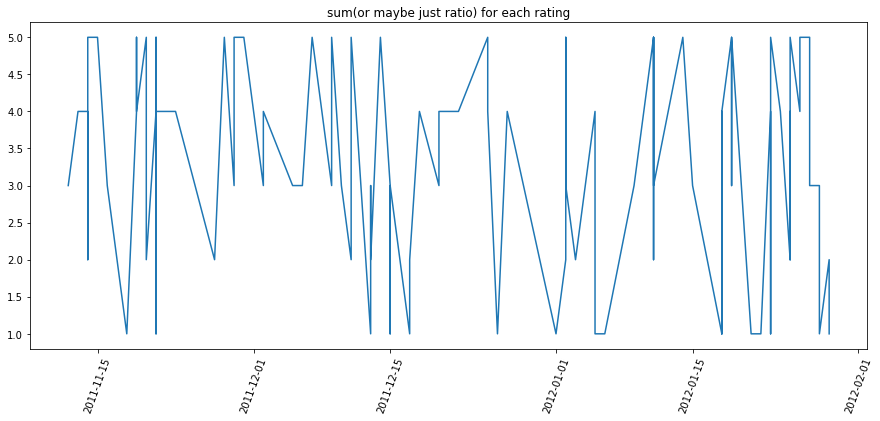

In [156]:
plt.figure(5, figsize=(15,6))
plt.plot(result3.creation_date[:100], result3.sentiment[:100])
plt.title("sum(or maybe just ratio) for each rating")
plt.xticks(rotation=70)
plt.yticks()
plt.show()

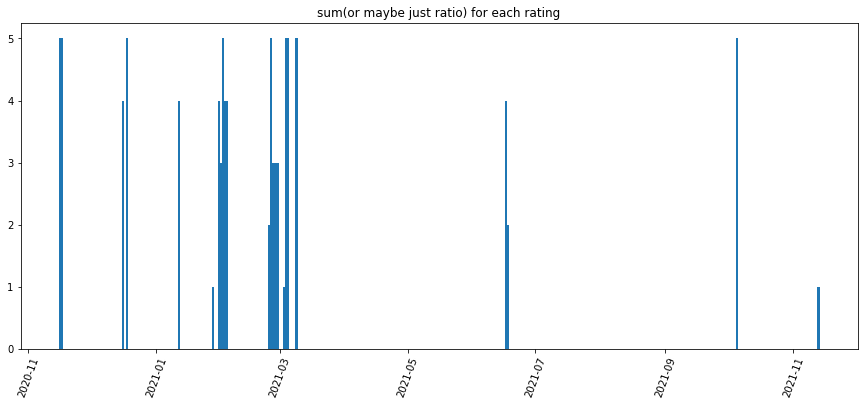

In [102]:
plt.figure(4, figsize=(15,6))
plt.bar(result3.creation_date, result3.sentiment)
plt.title("sum(or maybe just ratio) for each rating")
plt.xticks(rotation=70)
plt.yticks()
plt.show()

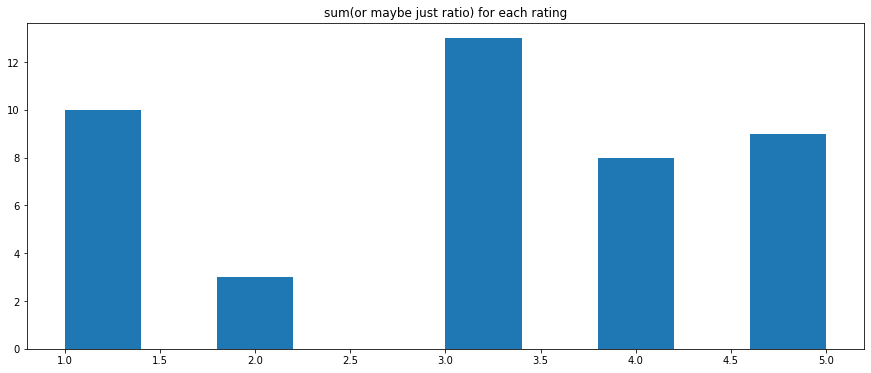

In [75]:
plt.figure(3, figsize=(15,6))
plt.hist(result.sentiment)
plt.title("sum(or maybe just ratio) for each rating")
plt.xticks()
plt.yticks()
plt.show()
# plt.hist(x)

In [35]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16143 entries, 0 to 99273
Data columns (total 83 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  776 non-null    object 
 1   allow_live_comments            453 non-null    object 
 2   author                         8093 non-null   object 
 3   author_flair_css_class         993 non-null    object 
 4   author_flair_richtext          2804 non-null   object 
 5   author_flair_text              103 non-null    object 
 6   author_flair_type              2804 non-null   object 
 7   author_fullname                6187 non-null   object 
 8   author_patreon_flair           1856 non-null   object 
 9   author_premium                 230 non-null    object 
 10  awarders                       287 non-null    object 
 11  can_mod_post                   3416 non-null   object 
 12  contest_mode                   4277 non-null  